In [727]:
%matplotlib inline

import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.stats import truncnorm
import math

In [715]:
#from adaptive_surrogate import local_marg_ll

# Signal-in-white-noise model: simulation with a uniform prior

$$\theta_i \sim \mathcal{U}[-\frac {\tau} {i^{\alpha + 1/2}}, \frac {\tau} {i^{\alpha + 1/2}}]$$

## Construction of the data

In [805]:
N = 300 # number of observed coefficients
tau = 10
n = 4000 # size of the dataset
m = 40 # number of machines
alpha = 1 # smoothness parameter
sigma = 1

### True signals

In [806]:
# from the uniform prior
theta_1 = tau * (np.random.random(N) * 2 - 1) / (np.arange(1,N+1,1) ** (alpha + 0.5))

# from Szabo 15
theta_2 = np.sin(10 * np.arange(1,N+1,1)) / (np.arange(1,N+1,1)) ** 2.25

# from Szabo 17
theta_3 = np.sin(np.arange(1.0,N+1.0,1.0)) * np.sqrt(2) / (np.arange(1.0,N+1.0,1.0)) ** 1.5

### Generates noisy samples

In [807]:
# generates m samples of the first N coefficients

def generate_data(theta=theta_2, m=m):

    return np.tile(theta, (m,1)) + np.sqrt(sigma * m / n) * np.random.normal(size=(m,N))


data = generate_data(theta_2, m)
data_1 = generate_data(theta_1, m)
data_3 = generate_data(theta_3, m)

Text(0,0.5,'Fourier coefficients')

<Figure size 432x288 with 0 Axes>

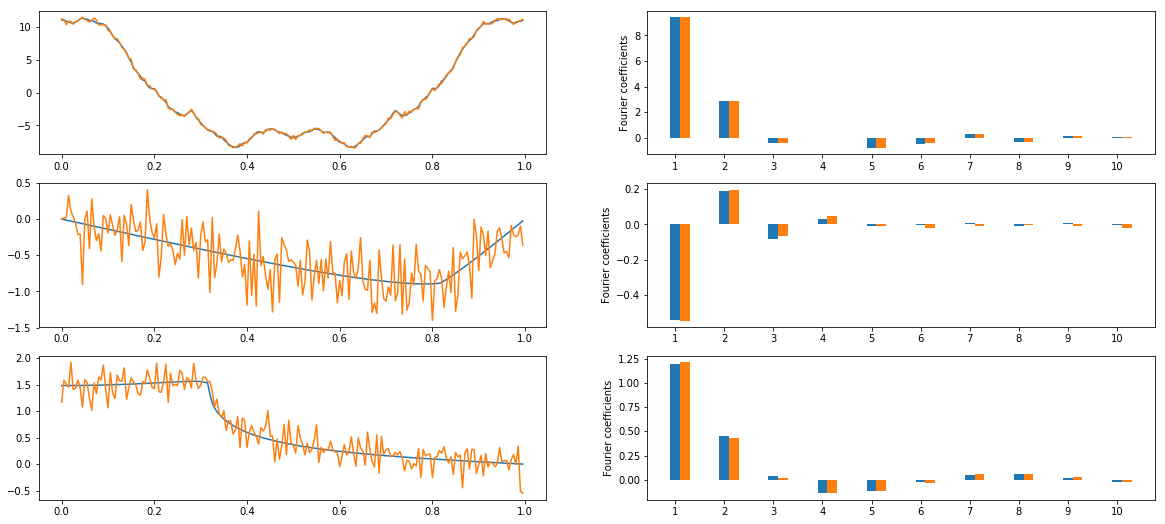

In [808]:
# plot of the signal and the coefficients

plt.figure()

fig, ax = plt.subplots(3,2, figsize=(20/1,9/1))

a = ax[0,0]
X = np.arange(0,1,0.005)
Y = [np.sum(theta_1[:N//2] * np.cos(2*np.pi*(np.arange(1,N//2+1,1) * x)))
     + np.sum(theta_1[N//2:] * np.sin(2*np.pi*(np.arange(1,N//2+1,1) * x))) for x in X]
Y_n = [np.sum(np.mean(data_1,axis=0)[:N//2] * np.cos(2*np.pi*(np.arange(1,N//2+1,1) * x)))
       + np.sum(np.mean(data_1,axis=0)[N//2:] * np.sin(2*np.pi*(np.arange(1,N//2+1,1) * x))) for x in X]
a.plot(X,Y)
a.plot(X,Y_n)

a = ax[0,1]
index = np.arange(1,11,1)
bar_width = 0.2
opacity = 1
a.bar(index, theta_1[:10], bar_width, align='center', alpha=opacity)
a.bar(index + bar_width, np.mean(data_1,axis=0)[:10], bar_width, align='center', alpha=opacity)
a.set_xticks(index)
a.set_ylabel('Fourier coefficients')


a = ax[1,0]
Y = [np.sum(theta_2 * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
Y_n = [np.sum(np.mean(data,axis=0) * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
a.plot(X,Y)
a.plot(X,Y_n)

a = ax[1,1]
a.bar(index, theta_2[:10], bar_width, align='center', alpha=opacity)
a.bar(index + bar_width, np.mean(data,axis=0)[:10], bar_width, align='center', alpha=opacity)
a.set_xticks(index)
a.set_ylabel('Fourier coefficients')

a = ax[2,0]
Y = [np.sum(theta_3 * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
Y_n = [np.sum(np.mean(data_3,axis=0) * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
a.plot(X,Y)
a.plot(X,Y_n)

a = ax[2,1]
a.bar(index, theta_3[:10], bar_width, align='center', alpha=opacity)
a.bar(index + bar_width, np.mean(data_3,axis=0)[:10], bar_width, align='center', alpha=opacity)
a.set_xticks(index)
a.set_ylabel('Fourier coefficients')

<Figure size 432x288 with 0 Axes>

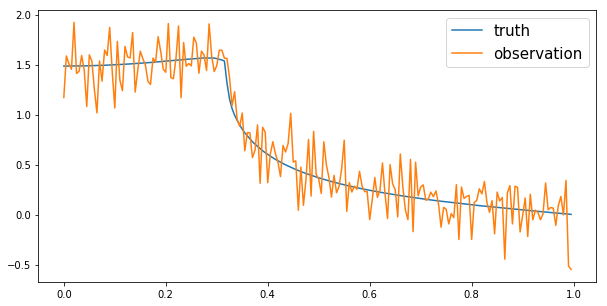

In [809]:
plt.figure()
fig, ax = plt.subplots(1,1, figsize=(10/1,5/1))
Y = [np.sum(theta_3 * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
Y_n = [np.sum(np.mean(data_3,axis=0) * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
ax.plot(X,Y, label="truth")
ax.plot(X,Y_n,label="observation")
ax.legend(fontsize = 15)

fig.savefig("signal.pdf")

## Distributed inference

Non-adaptive case: $\alpha$ and $\tau$ are chosen as the optimal values.

### Naive averaging

With a uniform prior, local posterior distributions are truncated normals (simulation with the library truncnorm)

#### Posterior distibutions

In [810]:
def sample_post_unif(data_3,p,tau):
    
    post = np.zeros((N,p))
    post_nd = np.zeros((N,p))

    for i in range(1, N+1):
    
        samp = np.zeros((m,p))
        
        born = tau / (i ** (alpha + 0.5))

        for j in range(m):

            samp[j,] = truncnorm.rvs(-born, born, loc = data_3[j,i-1], scale = sigma * np.sqrt(m/n), size=p)

        post[i-1,] = np.mean(samp, axis = 0)
        
        post_nd[i-1,] = truncnorm.rvs(-born, born, loc = np.mean(data_3[:,i-1]), scale = sigma / np.sqrt(n), size=p)
    
    return (post, post_nd)

In [811]:
# Sample p values from each local posterior distribution

p = 500

post = np.zeros((N,p))

for i in range(1, N+1):
    
    samp = np.zeros((m,p))

    for j in range(m):
        
        born = tau / (i ** (alpha + 0.5))
        
        samp[j,] = truncnorm.rvs(-born, born, loc = data_3[j,i-1], scale = sigma * np.sqrt(m/n), size=p)
        
    post[i-1,] = np.mean(samp, axis = 0)
    
    
# Comparison with the non-distributed case

post_nd = np.zeros((N,p))

for i in range(1, N+1):
        
    born = tau / (i ** (alpha + 0.5))
        
    post_nd[i-1,] = truncnorm.rvs(-born, born, loc = np.mean(data_3[:,i-1]), scale = sigma / np.sqrt(n), size=p)
    


In [812]:
# Sample p values from each local posterior distribution with Gaussian prior

p = 500

post_gauss = np.zeros((N,p))

for i in range(1, N+1):
    
    samp = np.zeros((m,p))

    for j in range(m):
        
        samp[j,] = np.random.normal(loc = data_3[j,i-1] * n / (n + sigma ** 2 * m * i ** (2*alpha + 1)),
                                                             scale = sigma * math.sqrt(m/(n + sigma ** 2 * m * i ** (1 + 2*alpha))),
                                                                                       size=p)
        
    post_gauss[i-1,] = np.mean(samp, axis = 0)
    
# Comparison with the non-distributed case

post_gauss_nd = np.zeros((N,p))

for i in range(1, N+1):
        
    post_gauss_nd[i-1,] = np.random.normal(loc = np.mean(data_3[:,i-1]) * n / (n + sigma ** 2 * i ** (2*alpha + 1)),
                                           scale = sigma / math.sqrt(n + sigma ** 2 * i ** (2*alpha + 1)), size=p)

<Figure size 432x288 with 0 Axes>

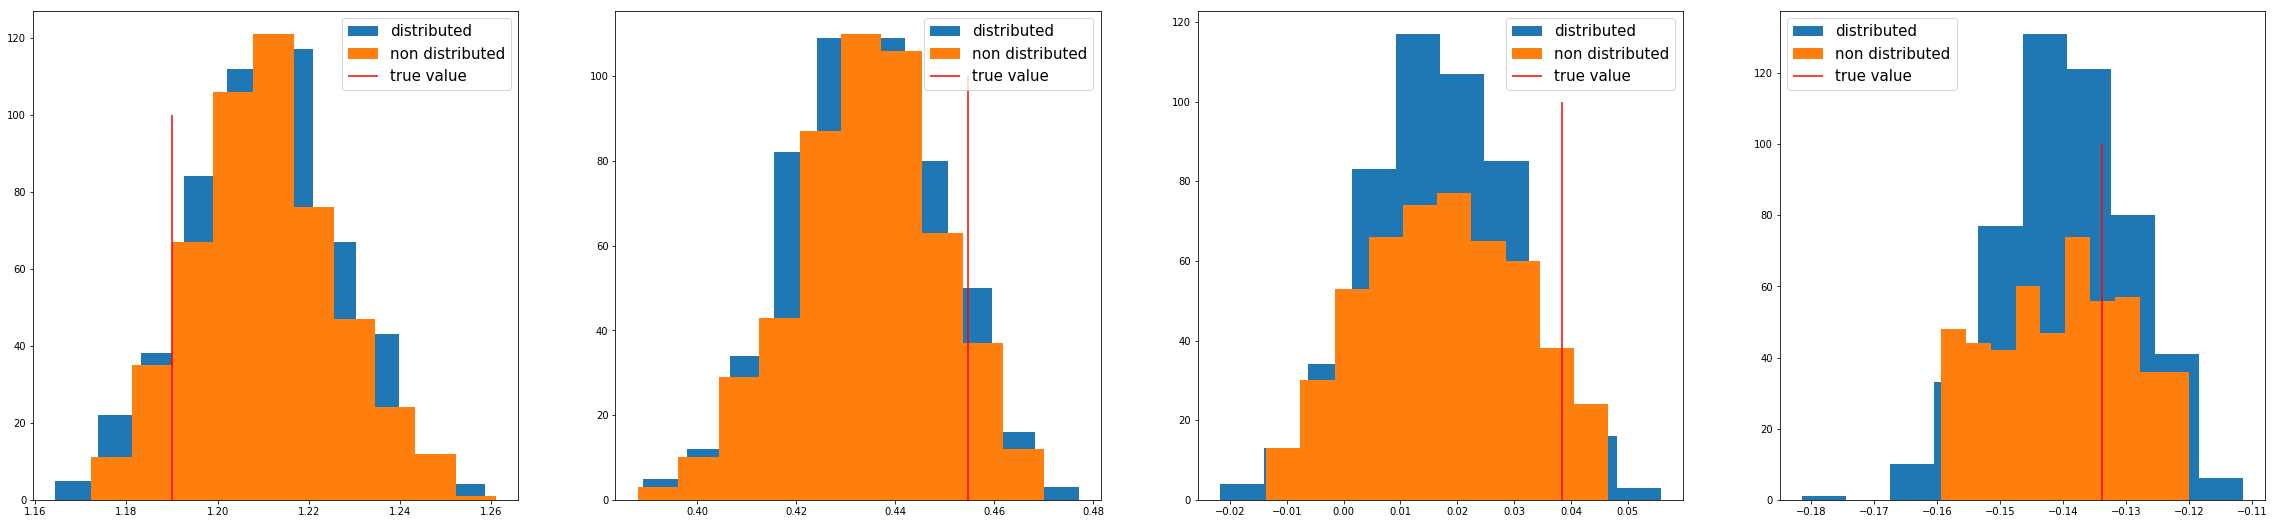

In [813]:
# Plots of the global posterior densities of the first coefficients

plt.figure()

fig, ax = plt.subplots(1,4, figsize=(40/1,9/1))

a = ax[0]
a.hist(post[0,], bins = 10, label="distributed")
a.hist(post_nd[0,], bins = 10, label="non distributed")
a.vlines((theta_3[0]), 0, 100, colors=("red"), label="true value")
a.legend(fontsize = 15)

a = ax[1]
a.hist(post[1,], bins = 10, label="distributed")
a.hist(post_nd[1,], bins = 10, label="non distributed")
a.vlines((theta_3[1]), 0, 100, colors=("red"), label="true value")
a.legend(fontsize = 15)

a = ax[2]
a.hist(post[2,], bins = 10, label="distributed")
a.hist(post_nd[2,], bins = 10, label="non distributed")
a.vlines((theta_3[2]), 0, 100, colors=("red"), label="true value")
a.legend(fontsize = 15)


a = ax[3]
a.hist(post[3,], bins = 10, label="distributed")
a.hist(post_nd[3,], bins = 10, label="non distributed")
a.vlines((theta_3[3]), 0, 100, colors=("red"), label="true value")
a.legend(fontsize = 15)

#### Estimated signal and coefficients

In [814]:
X = np.arange(0,1,0.01)
samples = np.zeros((p,X.shape[0]))
samples_nd = np.zeros((p,X.shape[0]))

for k in range(p):
    
    samples[k,:] = [np.sum(post[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    samples_nd[k,:] = [np.sum(post_nd[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    
samp_mean = np.mean(samples, axis = 0)
samp_std = np.std(samples, axis = 0)
samp_nd_mean = np.mean(samples_nd, axis = 0)
samp_nd_std = np.std(samples_nd, axis = 0)

<Figure size 432x288 with 0 Axes>

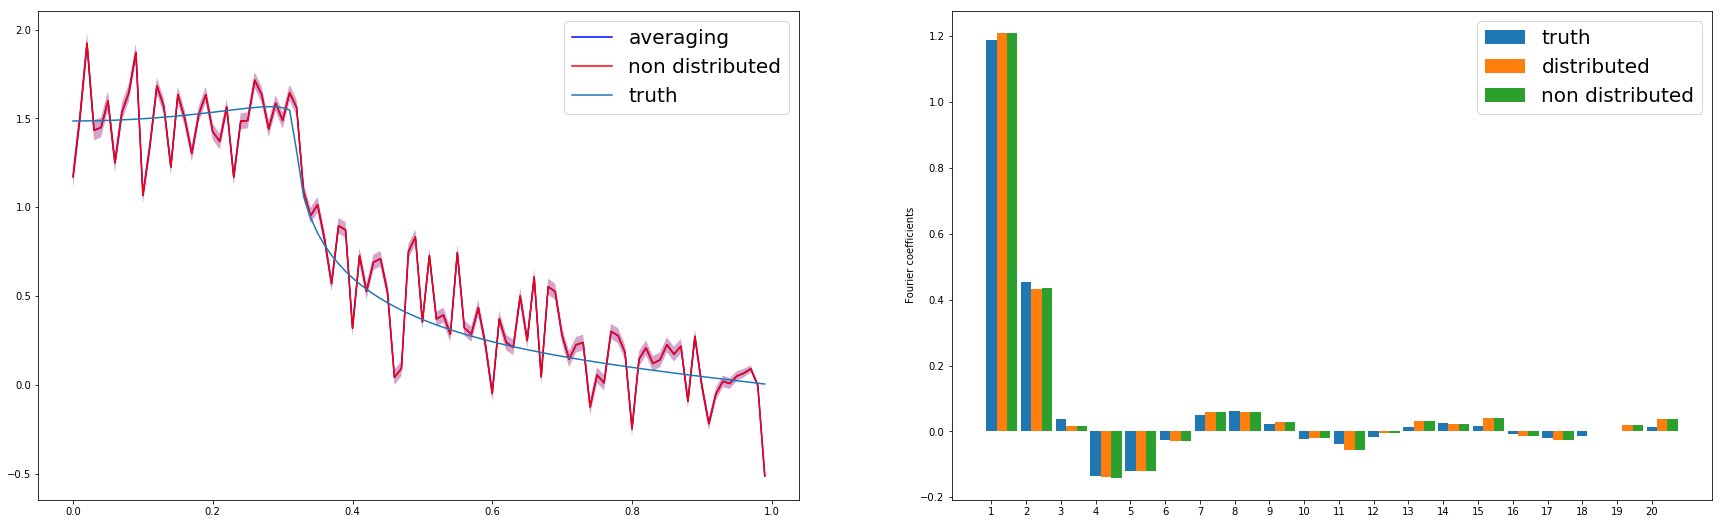

In [815]:
# Plots of the estimated signal and coefficients

est_coeff = np.mean(post, axis = 1)
est_coeff_nd = np.mean(post_nd, axis = 1)

est_coeff_std = np.std(post, axis = 1)
est_coeff_nd_std = np.std(post_nd, axis = 1)

plt.figure()

fig, ax = plt.subplots(1,2, figsize=(30/1,9/1))

a = ax[0]
X = np.arange(0,1,0.01)
#Y = [np.sum(est_coeff * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
Y = [np.sum(est_coeff * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
Y_min = [np.sum((est_coeff - 2 * est_coeff_std)* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
Y_max = [np.sum((est_coeff + 2 * est_coeff_std)* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
#Y_nd = [np.sum(est_coeff_nd * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
Y_nd = [np.sum(est_coeff_nd * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
Y_nd_min = [np.sum((est_coeff_nd - 2 * est_coeff_nd_std)* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
Y_nd_max = [np.sum((est_coeff_nd + 2 * est_coeff_nd_std)* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]                  
Y_true = [np.sum(theta_3 * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
#Y_true = [np.sum(theta_2 * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
a.plot(X,samp_mean,"blue",label="averaging")
a.plot(X,samp_nd_mean,"red",label="non distributed")
a.plot(X,Y_true, label="truth")
a.fill_between(X, samp_mean - 2*samp_std, samp_mean + 2*samp_std, facecolor="blue", alpha=0.2)
a.fill_between(X, samp_nd_mean - 2*samp_nd_std, samp_nd_mean + 2*samp_nd_std, facecolor="red", alpha=0.2)
a.legend(fontsize = 20)

a = ax[1]
index = np.arange(1,21,1)
bar_width = 0.3
opacity = 1
a.bar(index, theta_3[:20], bar_width, align='center', alpha=opacity, label="truth")
a.bar(index + bar_width, est_coeff[:20], bar_width, align='center', alpha=opacity, label="distributed")
a.bar(index + 2*bar_width, est_coeff_nd[:20], bar_width, align='center', alpha=opacity, label="non distributed")
a.set_xticks(index)
a.set_ylabel('Fourier coefficients')
a.legend(fontsize = 20)

No difference between the simple averaging and the non-distributed case ?

Overestimating the high frequencies, leading to an erratic signal.

Too small estimated errors.

In [816]:
X = np.arange(0,1,0.01)
samples = np.zeros((p,X.shape[0]))
samples_nd = np.zeros((p,X.shape[0]))

for k in range(p):
    
    samples[k,:] = [np.sum(post_gauss[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    samples_nd[k,:] = [np.sum(post_gauss_nd[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    
samp_mean = np.mean(samples, axis = 0)
samp_std = np.std(samples, axis = 0)
samp_nd_mean = np.mean(samples_nd, axis = 0)
samp_nd_std = np.std(samples_nd, axis = 0)

<Figure size 432x288 with 0 Axes>

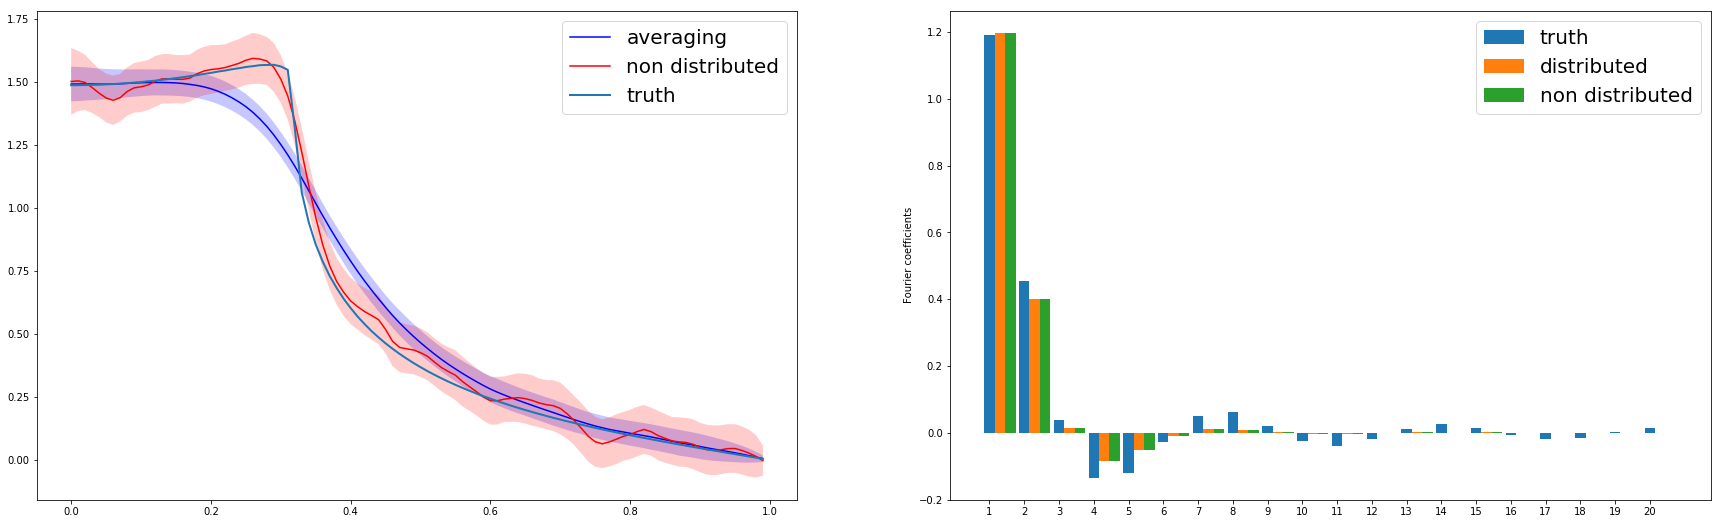

In [817]:
est_coeff_gauss = np.mean(post_gauss, axis = 1)
est_coeff_gauss_nd = np.mean(post_gauss_nd, axis = 1)

est_coeff_gauss_std = np.std(post_gauss, axis = 1)
est_coeff_gauss_nd_std = np.std(post_gauss_nd, axis = 1)

plt.figure()

fig, ax = plt.subplots(1,2, figsize=(30/1,9/1))

a = ax[0]
X = np.arange(0,1,0.01)
#Y = [np.sum(est_coeff_gauss * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
Y = [np.sum(est_coeff_gauss * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
Y_min = [np.sum((est_coeff_gauss - 2 * est_coeff_gauss_std)* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
Y_max = [np.sum((est_coeff_gauss + 2 * est_coeff_gauss_std)* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
#Y_nd = [np.sum(est_coeff_nd * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
Y_nd = [np.sum(est_coeff_gauss_nd * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
Y_nd_min = [np.sum((est_coeff_gauss_nd - 2 * est_coeff_gauss_nd_std)* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
Y_nd_max = [np.sum((est_coeff_gauss_nd + 2 * est_coeff_gauss_nd_std)* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]         
Y_true = [np.sum(theta_3 * np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
#Y_true = [np.sum(theta_2 * np.sqrt(2) * np.sin(np.pi * np.arange(1,N+1,1) * x)) for x in X]
a.plot(X,samp_mean,"blue",label="averaging")
a.plot(X,samp_nd_mean,"red",label="non distributed")
a.plot(X,Y_true, linewidth=2, label="truth")
a.fill_between(X, samp_mean - 2*samp_std, samp_mean + 2*samp_std, facecolor="blue", alpha=0.22)
a.fill_between(X, samp_nd_mean - 2*samp_nd_std, samp_nd_mean + 2*samp_nd_std, facecolor="red", alpha=0.2)
a.legend(fontsize = 20)

a = ax[1]
index = np.arange(1,21,1)
bar_width = 0.3
opacity = 1
a.bar(index, theta_3[:20], bar_width, align='center', alpha=opacity, label="truth")
a.bar(index + bar_width, est_coeff_gauss[:20], bar_width, align='center', alpha=opacity, label="distributed")
a.bar(index + 2*bar_width, est_coeff_gauss[:20], bar_width, align='center', alpha=opacity, label="non distributed")
a.set_xticks(index)
a.set_ylabel('Fourier coefficients')
a.legend(fontsize = 20)

<Figure size 432x288 with 0 Axes>

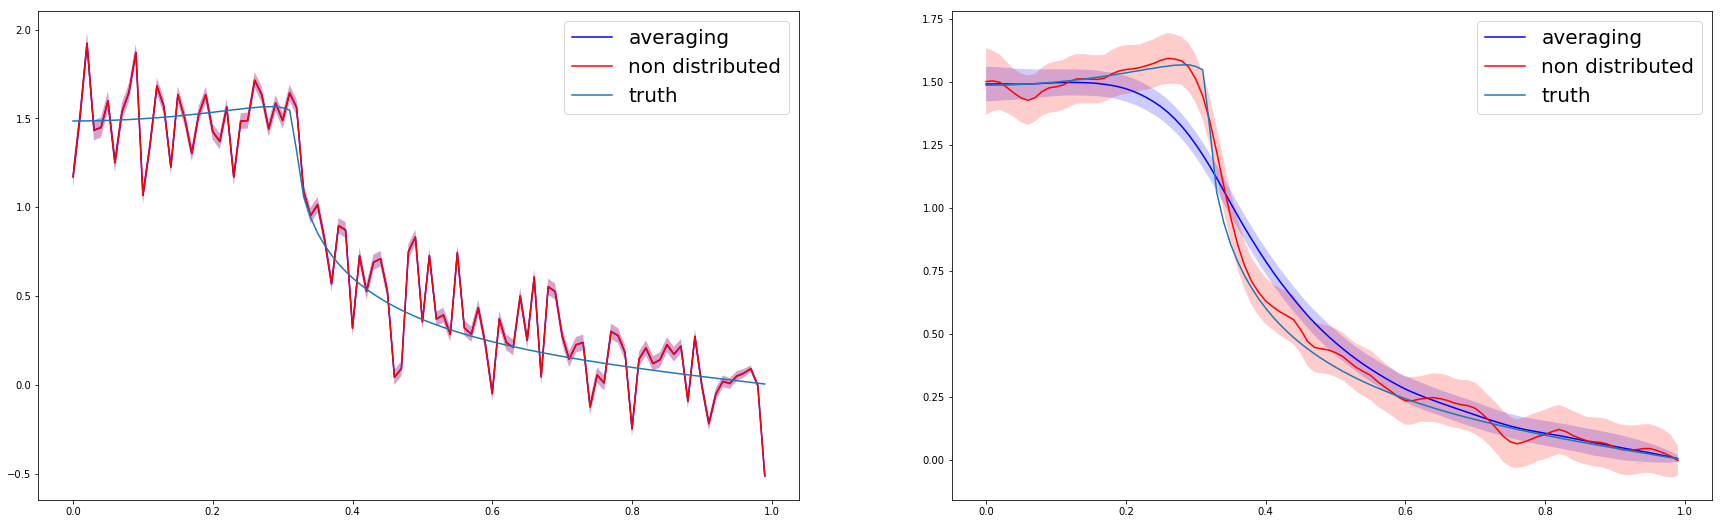

In [818]:
p=500
X = np.arange(0,1,0.01)
samples = np.zeros((p,X.shape[0]))
samples_nd = np.zeros((p,X.shape[0]))
samples_g = np.zeros((p,X.shape[0]))
samples_g_nd = np.zeros((p,X.shape[0]))

for k in range(p):
    
    samples[k,:] = [np.sum(post[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    samples_nd[k,:] = [np.sum(post_nd[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    samples_g[k,:] = [np.sum(post_gauss[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    samples_g_nd[k,:] = [np.sum(post_gauss_nd[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    
samp_mean = np.mean(samples, axis = 0)
samp_std = np.std(samples, axis = 0)
samp_nd_mean = np.mean(samples_nd, axis = 0)
samp_nd_std = np.std(samples_nd, axis = 0)
samp_mean_g = np.mean(samples_g, axis = 0)
samp_std_g = np.std(samples_g, axis = 0)
samp_nd_mean_g = np.mean(samples_g_nd, axis = 0)
samp_nd_std_g = np.std(samples_g_nd, axis = 0)

plt.figure()
fig, ax = plt.subplots(1,2, figsize=(30/1,9/1))

a = ax[0]
a.plot(X,samp_mean,"blue",label="averaging")
a.plot(X,samp_nd_mean,"red",label="non distributed")
a.plot(X,Y_true, label="truth")
a.fill_between(X, samp_mean - 2*samp_std, samp_mean + 2*samp_std, facecolor="blue", alpha=0.2)
a.fill_between(X, samp_nd_mean - 2*samp_nd_std, samp_nd_mean + 2*samp_nd_std, facecolor="red", alpha=0.2)
a.legend(fontsize = 20)

a = ax[1]
a.plot(X,samp_mean_g,"blue",label="averaging")
a.plot(X,samp_nd_mean_g,"red",label="non distributed")
a.plot(X,Y_true, label="truth")
a.fill_between(X, samp_mean_g - 2*samp_std_g, samp_mean_g + 2*samp_std_g, facecolor="blue", alpha=0.2)
a.fill_between(X, samp_nd_mean_g - 2*samp_nd_std_g, samp_nd_mean_g + 2*samp_nd_std_g, facecolor="red", alpha=0.2)
a.legend(fontsize = 20)

fig.savefig("unif1.pdf")

With the Gaussian prior, the estimated signal is much smoother (underestimates high frequencies).

### Adjusted likelihoods and averaging

The local likelihoods are raised to the power m. Because they are normal, their variance is thus multiplied by $\sqrt m$.

In [819]:
p = 500

# uniform prior
post_padj = np.zeros((N,p))

for i in range(1, N+1):
    
    samp = np.zeros((m,p))

    for j in range(m):
        
        born = tau / (i ** (alpha + 0.5))
        
        samp[j,] = truncnorm.rvs(-born, born, loc = data_3[j,i-1], scale = sigma * m / np.sqrt(n), size=p)
        
    post_padj[i-1,] = np.mean(samp, axis = 0)
    
est_coeff_padj = np.mean(post_padj, axis = 1)

post_padj_gauss = np.zeros((N,p))

for i in range(1, N+1):
    
    samp = np.zeros((m,p))

    for j in range(m):
        
        samp[j,] = np.random.normal(loc = data_3[j,i-1] * n / (n + sigma ** 2 * m * i ** (2*alpha + 1)),
                                                             scale = sigma / np.sqrt((n + sigma ** 2 * m * i ** (1 + 2*alpha))),
                                                                                       size=p)
        
    post_padj_gauss[i-1,] = np.mean(samp, axis = 0)


<Figure size 432x288 with 0 Axes>

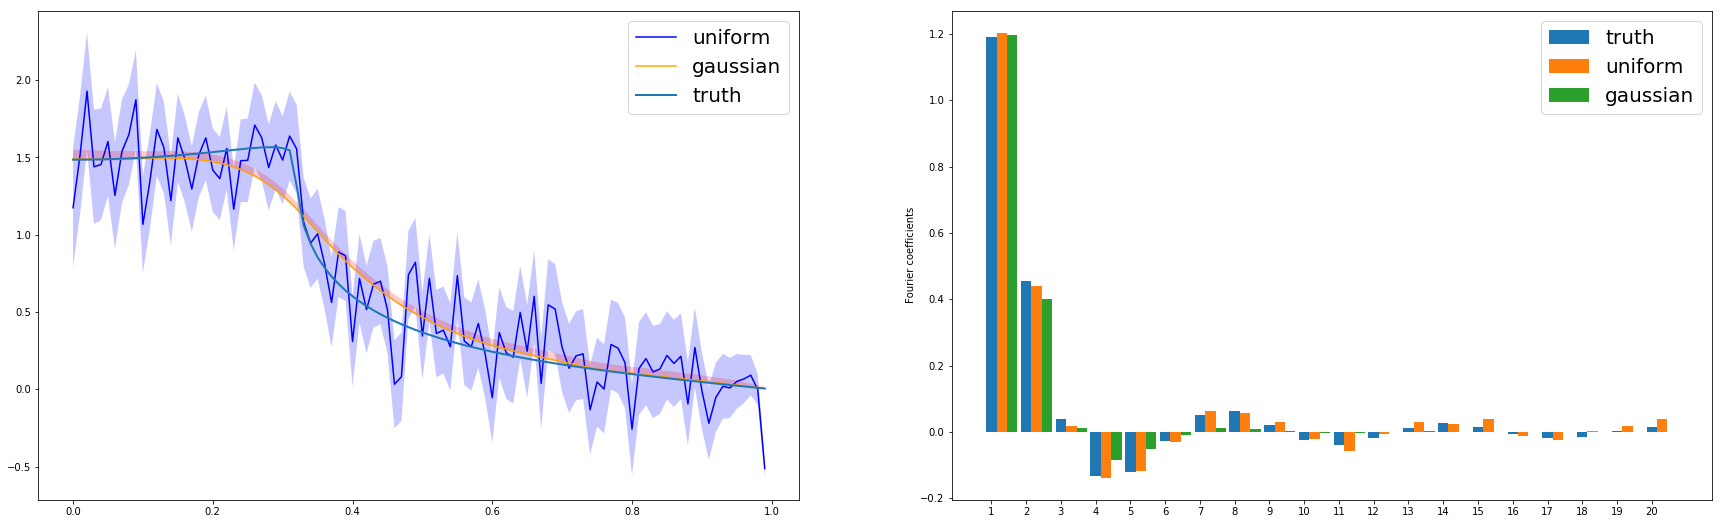

In [820]:
X = np.arange(0,1,0.01)
samples = np.zeros((p,X.shape[0]))
samples_g = np.zeros((p,X.shape[0]))

for k in range(p):
    
    samples[k,:] = [np.sum(post_padj[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    samples_g[k,:] = [np.sum(post_padj_gauss[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    
samp_mean = np.mean(samples, axis = 0)
samp_std = np.std(samples, axis = 0)
samp_g_mean = np.mean(samples_g, axis = 0)
samp_g_std = np.std(samples_g, axis = 0)

est_coeff = np.mean(post_padj, axis = 1)
est_coeff_gauss = np.mean(post_padj_gauss, axis = 1)

plt.figure()
fig, ax = plt.subplots(1,2, figsize=(30/1,9/1))

a = ax[0]
X = np.arange(0,1,0.01)
a.plot(X,samp_mean,"blue",label="uniform")
a.plot(X,samp_g_mean,"orange",label="gaussian")
a.plot(X,Y_true, linewidth=2, label="truth")
a.fill_between(X, samp_mean - 2*samp_std, samp_mean + 2*samp_std, facecolor="blue", alpha=0.22)
a.fill_between(X, samp_g_mean - 2*samp_g_std, samp_g_mean + 2*samp_nd_std, facecolor="red", alpha=0.2)
a.legend(fontsize = 20)

a = ax[1]
index = np.arange(1,21,1)
bar_width = 0.3
opacity = 1
a.bar(index, theta_3[:20], bar_width, align='center', alpha=opacity, label="truth")
a.bar(index + bar_width, est_coeff[:20], bar_width, align='center', alpha=opacity, label="uniform")
a.bar(index + 2*bar_width, est_coeff_gauss[:20], bar_width, align='center', alpha=opacity, label="gaussian")
a.set_xticks(index)
a.set_ylabel('Fourier coefficients')
a.legend(fontsize = 20)

The credible sets are larger with the adjusted likelihoods.

### Adjusted priors and averaging

The generalized local posterior raised to the power $m$ the prior. For the uniform prior, truncated normals in the posterior will have lower bounds.

In [821]:
p = 500

# uniform prior
post_uadj = np.zeros((N,p))

for i in range(1, N+1):
    
    samp = np.zeros((m,p))

    for j in range(m):
        
        born = (tau / (i ** (alpha + 0.5))) ** m
        
        samp[j,] = truncnorm.rvs(-born, born, loc = data_3[j,i-1], scale = sigma * m / np.sqrt(n), size=p)
        
    post_uadj[i-1,] = np.mean(samp, axis = 0)
    
est_coeff_uadj = np.mean(post_padj, axis = 1)

post_uadj_gauss = np.zeros((N,p))

for i in range(1, N+1):
    
    samp = np.zeros((m,p))

    for j in range(m):
        
        samp[j,] = np.random.normal(loc = data_3[j,i-1] * n / (n + sigma ** 2 * i ** (alpha + 0.5)),
                                                             scale = sigma * np.sqrt(m / (n + sigma ** 2 * i ** (0.5 + alpha))),
                                                                                       size=p)
        
    post_uadj_gauss[i-1,] = np.mean(samp, axis = 0)



/homes/sulem/.local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:6344: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)


<Figure size 432x288 with 0 Axes>

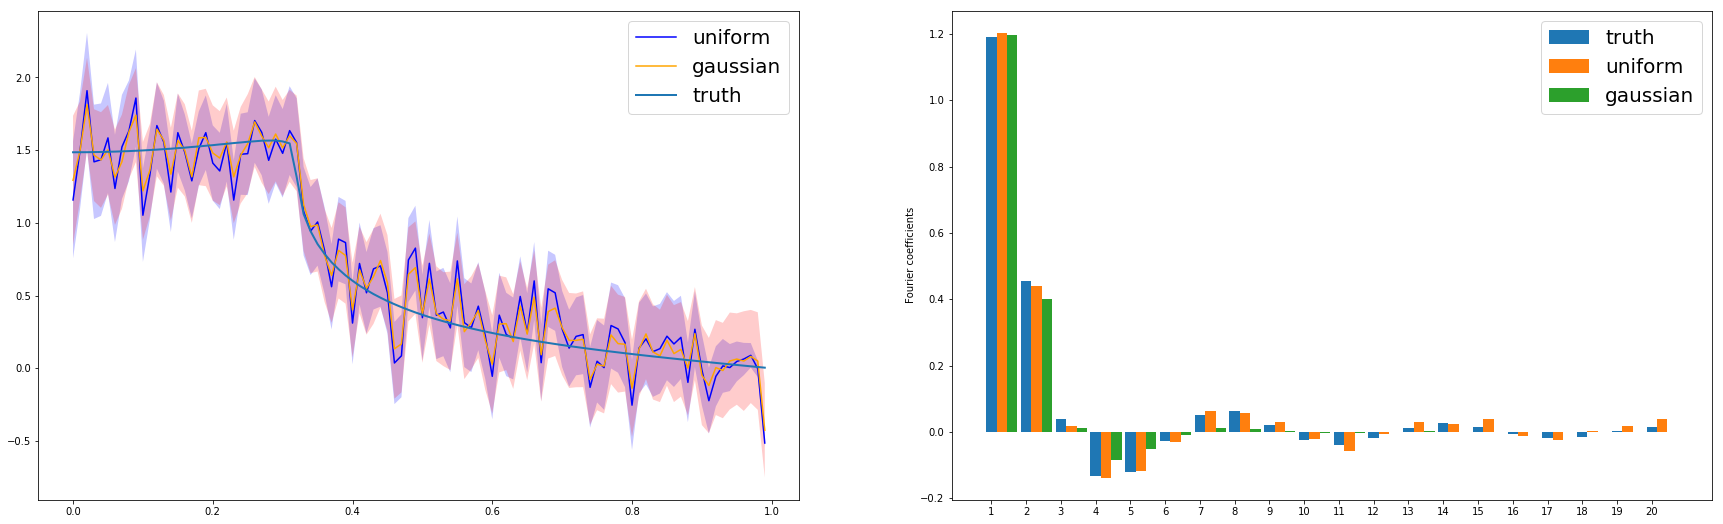

In [822]:
X = np.arange(0,1,0.01)
samples = np.zeros((p,X.shape[0]))
samples_g = np.zeros((p,X.shape[0]))

for k in range(p):
    
    samples[k,:] = [np.sum(post_uadj[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    samples_g[k,:] = [np.sum(post_uadj_gauss[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    
samp_mean = np.mean(samples, axis = 0)
samp_std = np.std(samples, axis = 0)
samp_g_mean = np.mean(samples_g, axis = 0)
samp_g_std = np.std(samples_g, axis = 0)

est_coeff = np.mean(post_padj, axis = 1)
est_coeff_gauss = np.mean(post_padj_gauss, axis = 1)

plt.figure()
fig, ax = plt.subplots(1,2, figsize=(30/1,9/1))

a = ax[0]
X = np.arange(0,1,0.01)
a.plot(X,samp_mean,"blue",label="uniform")
a.plot(X,samp_g_mean,"orange",label="gaussian")
a.plot(X,Y_true, linewidth=2, label="truth")
a.fill_between(X, samp_mean - 2*samp_std, samp_mean + 2*samp_std, facecolor="blue", alpha=0.22)
a.fill_between(X, samp_g_mean - 2*samp_g_std, samp_g_mean + 2*samp_g_std, facecolor="red", alpha=0.2)
a.legend(fontsize = 20)

a = ax[1]
index = np.arange(1,21,1)
bar_width = 0.3
opacity = 1
a.bar(index, theta_3[:20], bar_width, align='center', alpha=opacity, label="truth")
a.bar(index + bar_width, est_coeff[:20], bar_width, align='center', alpha=opacity, label="uniform")
a.bar(index + 2*bar_width, est_coeff_gauss[:20], bar_width, align='center', alpha=opacity, label="gaussian")
a.set_xticks(index)
a.set_ylabel('Fourier coefficients')
a.legend(fontsize = 20)

The Gaussian is less smooth than with the previous methods and is now closer to the uniform prior.

<Figure size 432x288 with 0 Axes>

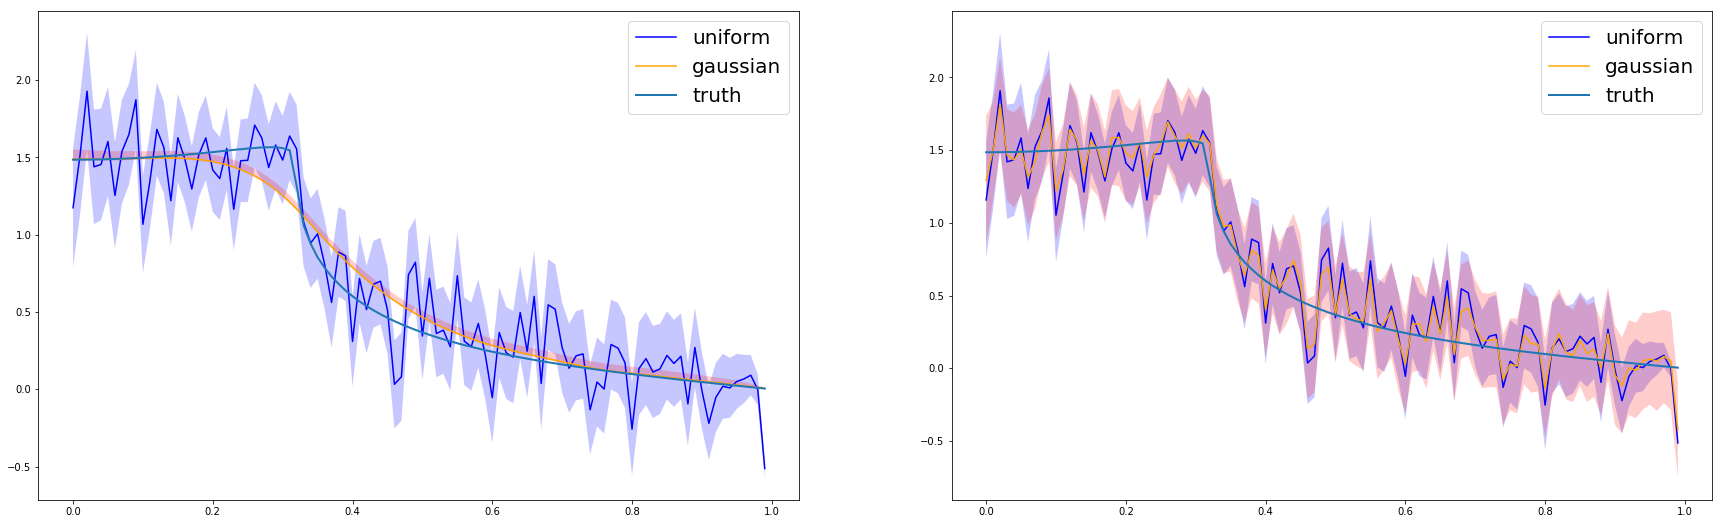

In [823]:
plt.figure()
fig, ax = plt.subplots(1,2, figsize=(30/1,9/1))

a = ax[0]
X = np.arange(0,1,0.01)
samples = np.zeros((p,X.shape[0]))
samples_g = np.zeros((p,X.shape[0]))

for k in range(p):
    
    samples[k,:] = [np.sum(post_padj[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    samples_g[k,:] = [np.sum(post_padj_gauss[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    
samp_mean = np.mean(samples, axis = 0)
samp_std = np.std(samples, axis = 0)
samp_g_mean = np.mean(samples_g, axis = 0)
samp_g_std = np.std(samples_g, axis = 0)
a.plot(X,samp_mean,"blue",label="uniform")
a.plot(X,samp_g_mean,"orange",label="gaussian")
a.plot(X,Y_true, linewidth=2, label="truth")
a.fill_between(X, samp_mean - 2*samp_std, samp_mean + 2*samp_std, facecolor="blue", alpha=0.22)
a.fill_between(X, samp_g_mean - 2*samp_g_std, samp_g_mean + 2*samp_nd_std, facecolor="red", alpha=0.2)
a.legend(fontsize = 20)

a = ax[1]
X = np.arange(0,1,0.01)
X = np.arange(0,1,0.01)
samples = np.zeros((p,X.shape[0]))
samples_g = np.zeros((p,X.shape[0]))

for k in range(p):
    
    samples[k,:] = [np.sum(post_uadj[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    samples_g[k,:] = [np.sum(post_uadj_gauss[:,k]* np.cos(np.pi * (np.arange(1.0,N+1.0,1.0) - 0.5) * x)) for x in X]
    
samp_mean = np.mean(samples, axis = 0)
samp_std = np.std(samples, axis = 0)
samp_g_mean = np.mean(samples_g, axis = 0)
samp_g_std = np.std(samples_g, axis = 0)
a.plot(X,samp_mean,"blue",label="uniform")
a.plot(X,samp_g_mean,"orange",label="gaussian")
a.plot(X,Y_true, linewidth=2, label="truth")
a.fill_between(X, samp_mean - 2*samp_std, samp_mean + 2*samp_std, facecolor="blue", alpha=0.22)
a.fill_between(X, samp_g_mean - 2*samp_g_std, samp_g_mean + 2*samp_g_std, facecolor="red", alpha=0.2)
a.legend(fontsize = 20)

fig.savefig("adjust.pdf")